In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from math import sqrt


c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [6]:
dn=pd.read_csv('C:/Abdelouaheb/perso/Ph/time_series_analysis/data/Electric_Production.csv', index_col='DATE', parse_dates=True)

In [5]:
df.tail(30)

,IPG2211A2N
DATE,
2015-08-01,110.5925
2015-09-01,101.9204
2015-10-01,91.5959
2015-11-01,93.0628
2015-12-01,103.2203
2016-01-01,117.0837
2016-02-01,106.6688
2016-03-01,95.3548
2016-04-01,89.3254


In [7]:
# Time based train-test splitting
valid = dn.loc['2015-08-01':]
df = dn.loc[:'2015-08-01']

In [8]:
df.shape

(368, 1)

In [9]:
# Understanding the data for time based train-test split
print(f'Start Date: {df.index.min()}')
print(f'End Date: {df.index.max()}')
print(f'Total Days: {len(df)}')

Start Date: 1985-01-01 00:00:00
End Date: 2015-08-01 00:00:00
Total Days: 368


In [10]:
# Check for missing values in the entire DataFrame
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
IPG2211A2N    0
dtype: int64


In [11]:
df.columns = ['value']
df.tail()


,value
DATE,
2015-04-01,89.7461
2015-05-01,91.0930
2015-06-01,102.6495
2015-07-01,111.6354
2015-08-01,110.5925


In [13]:

# Generate a sequence of dates spanning the range of your data
min_date = df.index.min()
max_date = df.index.max()
date_range = pd.date_range(start=min_date, end=max_date)

# Identify missing dates
missing_dates = date_range[~date_range.isin(df.index)]
missing_dates_list = missing_dates.tolist()
print("Missing dates:")
print(len(missing_dates_list))

Missing dates:
10802


In [66]:
df.shape[0]

397

In [14]:
# Generate a sequence of dates spanning the range of your data

# Generate a sequence of dates spanning the range of your data
min_date = df.index.min()
max_date = df.index.max()
date_range = pd.date_range(start=min_date, end=max_date)

# Identify missing dates
missing_dates = date_range[~date_range.isin(df.index)]

# Create DataFrame for missing dates with NaN values
missing_df = pd.DataFrame({'value': np.nan}, index=missing_dates)
missing_df = pd.DataFrame(index=missing_dates, columns=['value'])
# Concatenate original DataFrame with DataFrame for missing dates
dc = pd.concat([df, missing_df])

# Sort DataFrame by index (date)
dc.sort_index(inplace=True)

print(dc)

               value
1985-01-01   72.5052
1985-01-02       NaN
1985-01-03       NaN
1985-01-04       NaN
1985-01-05       NaN
...              ...
2015-07-28       NaN
2015-07-29       NaN
2015-07-30       NaN
2015-07-31       NaN
2015-08-01  110.5925

[11170 rows x 1 columns]


In [15]:
dc.reset_index(inplace=True)

dc=dc.rename(columns={"index": "DATE"})

print(dc)

            DATE     value
0     1985-01-01   72.5052
1     1985-01-02       NaN
2     1985-01-03       NaN
3     1985-01-04       NaN
4     1985-01-05       NaN
...          ...       ...
11165 2015-07-28       NaN
11166 2015-07-29       NaN
11167 2015-07-30       NaN
11168 2015-07-31       NaN
11169 2015-08-01  110.5925

[11170 rows x 2 columns]


In [16]:
# Rename the index to 'DATE'
dc.set_index('DATE', inplace=True)

print(dc)


               value
DATE                
1985-01-01   72.5052
1985-01-02       NaN
1985-01-03       NaN
1985-01-04       NaN
1985-01-05       NaN
...              ...
2015-07-28       NaN
2015-07-29       NaN
2015-07-30       NaN
2015-07-31       NaN
2015-08-01  110.5925

[11170 rows x 1 columns]


In [17]:
# Check for missing values in the entire DataFrame
missing_values = dc.isnull().sum()

# Display the count of missing values for each column
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
value    10802
dtype: int64


<Axes: xlabel='DATE'>

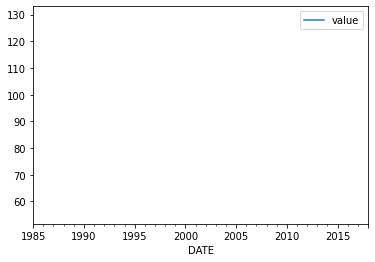

In [104]:
dc.plot()

<Figure size 432x288 with 0 Axes>

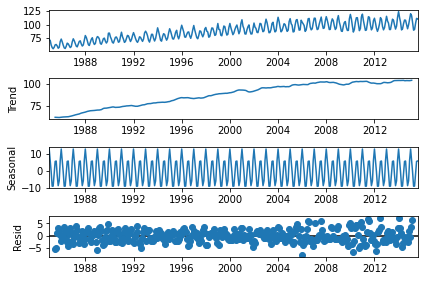

In [18]:
result = seasonal_decompose(df)

fig = plt.figure()  
fig = result.plot()
plt.show()

In [19]:
result=adfuller(df.value.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')


ADF Statistics:-2.2177366672247802
p-value:0.19987116175608627


In [20]:
result=adfuller(df.value.diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')


ADF Statistics:-6.9865733083977695
p-value:7.940503047364034e-10


c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


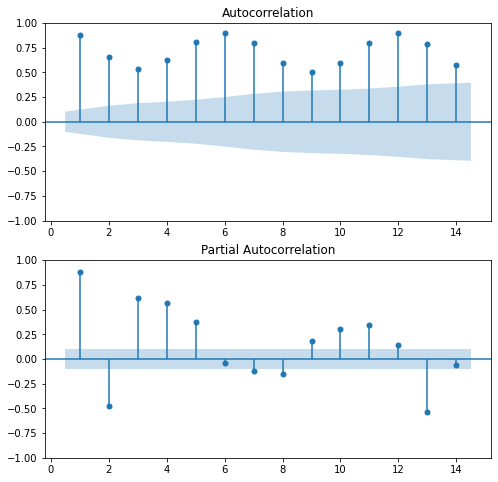

In [21]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(df,lags=14, zero=False, ax=ax1)
plot_pacf(df,lags=14, zero=False, ax=ax2)
plt.show()

In [22]:

import pmdarima as pm

In [23]:
results_arima=pm.auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=False, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (6) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2407.180, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2527.135, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2471.677, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2406.464, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2525.204, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2313.827, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2282.181, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2238.163, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2238.122, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2250.261, Time=0.08 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 1.412 seconds


In [24]:
model_arima=SARIMAX(df,order=(0,1,3))
results_arima=model_arima.fit()

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [25]:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  368
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -1121.131
Date:                Tue, 06 Feb 2024   AIC                           2250.261
Time:                        21:58:32   BIC                           2265.883
Sample:                    01-01-1985   HQIC                          2256.468
                         - 08-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1547      0.042      3.650      0.000       0.072       0.238
ma.L2         -0.4562      0.041    -10.998      0.000      -0.537      -0.375
ma.L3         -0.5491      0.046    -12.036      0.000      -0.639      -0.460
sigma2        26.2288      2.065     12.704      0.000      22.182      30.275
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.53   Prob(JB):                         0.43
Heteroskedasticity (H):               2.55   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

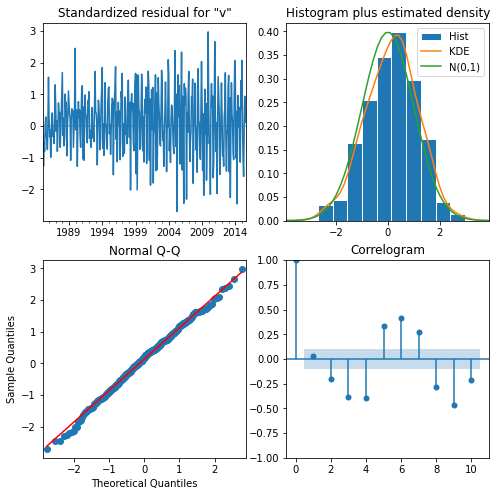

In [26]:
# Create the 4 diagostics plots
results_arima.plot_diagnostics(figsize=(8,8))
plt.show()

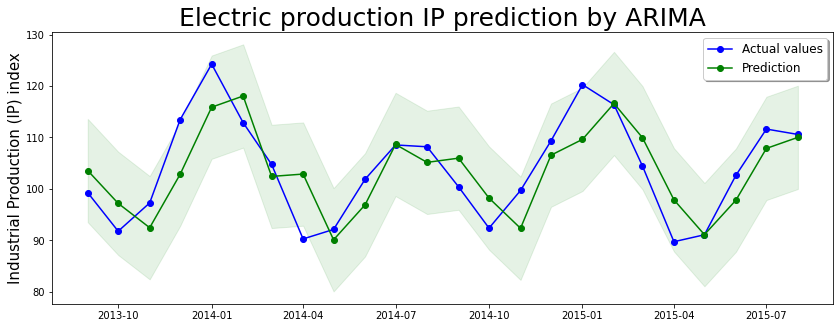

In [27]:
prediction_arima = results_arima.get_prediction(start=-24)
mean_prediction_arima=prediction_arima.predicted_mean
mean_prediction = mean_prediction_arima.rename("prediction")
confi_int_p_arima=prediction_arima.conf_int()
lower_limits_p_arima=confi_int_p_arima.iloc[:,0]
upper_limits_p_arima=confi_int_p_arima.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP prediction by ARIMA", fontsize=25)

plt.plot(df[-24:].index,df[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction_arima[-24:].index, mean_prediction_arima[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction_arima[-24:].index, lower_limits_p_arima, upper_limits_p_arima, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

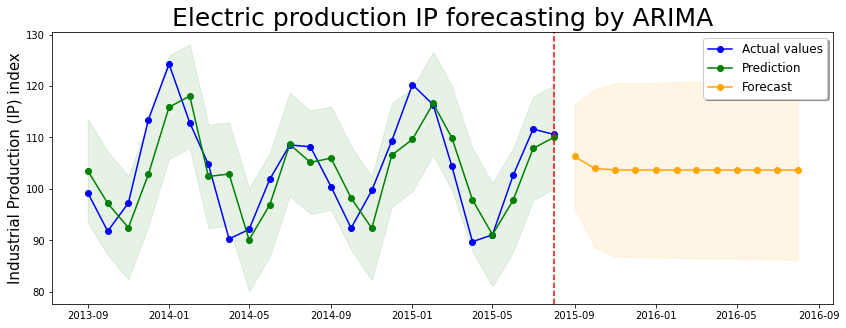

In [28]:
df_pred=df.iloc[-24:]
# Make ARIMA forecast of next 10 values
forecast_arima = results_arima.get_forecast(steps=12)
mean_forecast_arima=forecast_arima.predicted_mean
mean_forecast_arima = mean_forecast_arima.rename("prediction")
confi_int_f_arima=forecast_arima.conf_int()
lower_limits_f_arima=confi_int_f_arima.iloc[:,0]
upper_limits_f_arima=confi_int_f_arima.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by ARIMA", fontsize=25)

plt.plot(df[-24:].index,df[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p_arima, upper_limits_p_arima, alpha=0.1, color="green")

plt.plot(mean_forecast_arima[-24:].index,mean_forecast_arima[-24:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast_arima[-24:].index, lower_limits_f_arima, upper_limits_f_arima, alpha=0.1, color="orange")

plt.axvline(df_pred.iloc[-24:].index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [29]:
df_arima = pd.concat([mean_prediction_arima, mean_forecast_arima])

In [30]:
results_sarimax=pm.auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True,trend='ct')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1752.174, Time=1.27 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2202.815, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=1798.165, Time=0.50 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=1909.077, Time=0.56 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=1980.482, Time=0.63 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=1745.025, Time=0.76 sec
 ARIMA(1,1,1)(0,1,0)[6]             : AIC=2138.243, Time=0.67 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=1741.852, Time=1.71 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1751.010, Time=1.97 sec
 ARIMA(0,1,1)(2,1,0)[6]             : AIC=1784.762, Time=1.20 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=1799.205, Time=1.55 sec
 ARIMA(2,1,1)(2,1,0)[6]             : AIC=1766.886, Time=2.42 sec
 ARIMA(1,1,2)(2,1,0)[6]             : AIC=1761.889, Time=1.94 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=1808.621, Time=1.30 sec
 ARIMA(0,1,2)(2,1,0)[6]          

In [31]:
model_sarimax=SARIMAX(df,order=(2,1,2),  seasonal_order=(1, 1, 0, 6))
results_sarimax=model_sarimax.fit()

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starti

In [32]:
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  368
Model:             SARIMAX(2, 1, 2)x(1, 1, [], 6)   Log Likelihood                -852.872
Date:                            Tue, 06 Feb 2024   AIC                           1717.743
Time:                                    21:59:53   BIC                           1741.077
Sample:                                01-01-1985   HQIC                          1727.020
                                     - 08-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3242      0.068     -4.773      0.000      -0.457      -0.191
ar.L2          0.4509      0.065      6.912      0.000       0.323       0.579
ma.L1         -0.0505      0.043     -1.186      0.236      -0.134       0.033
ma.L2         -0.9344      0.043    -21.622      0.000      -1.019      -0.850
ar.S.L6       -0.8215      0.027    -30.815      0.000      -0.874      -0.769
sigma2         6.3951      0.420     15.223      0.000       5.572       7.218
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.39
Prob(Q):                              0.99   Prob(JB):                         0.02
Heteroskedasticity (H):               2.41   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

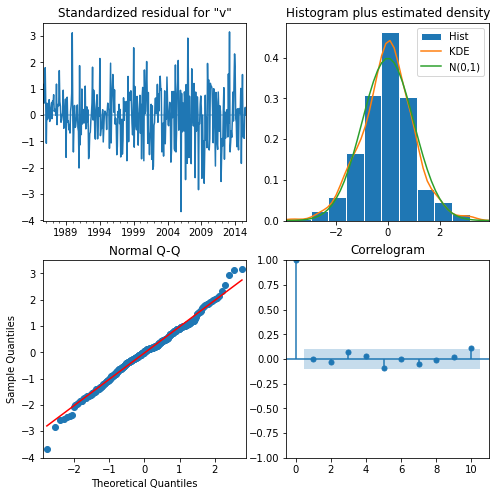

In [33]:
# Create the 4 diagostics plots
results_sarimax.plot_diagnostics(figsize=(8,8))
plt.show()

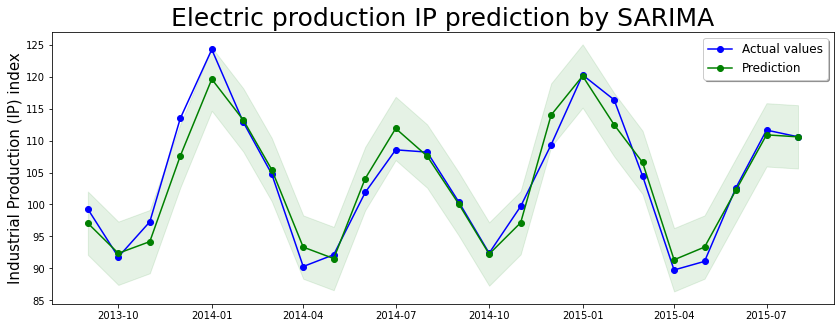

In [34]:
prediction = results_sarimax.get_prediction(start=-24)
mean_prediction=prediction.predicted_mean
mean_prediction = mean_prediction.rename("prediction")
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP prediction by SARIMA", fontsize=25)

plt.plot(df[-24:].index,df[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

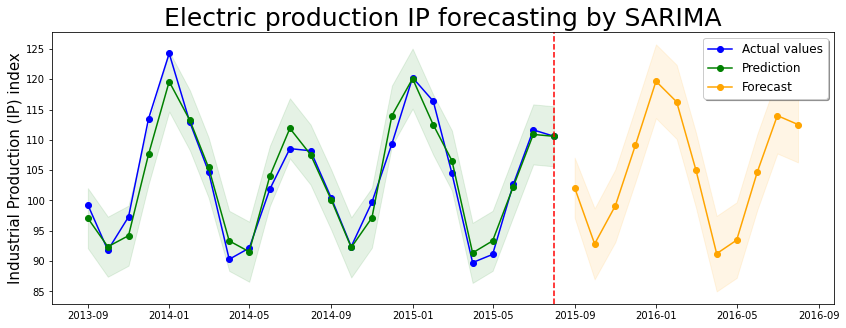

In [35]:
df_pred=df.iloc[-24:]
# Make ARIMA forecast of next 10 values
forecast = results_sarimax.get_forecast(steps=12)
mean_forecast=forecast.predicted_mean
mean_forecast = mean_forecast.rename("prediction")
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by SARIMA", fontsize=25)

plt.plot(df[-24:].index,df[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.plot(mean_forecast[-24:].index,mean_forecast[-24:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast[-24:].index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(df_pred.iloc[-24:].index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [36]:
rmse_arima = sqrt(mean_squared_error(df[-24:].values,mean_prediction_arima.values))
print(f"RMSE OF SARIMA MODEL : {rmse_arima:.2f}")

RMSE OF SARIMA MODEL : 5.98


In [37]:
rmse_sarima = sqrt(mean_squared_error(df[-24:].values,mean_prediction.values))
print(f"RMSE OF SARIMA MODEL : {rmse_sarima:.2f}")

RMSE OF SARIMA MODEL : 2.53


In [38]:
df_sarimax  = pd.concat([mean_prediction, mean_forecast])

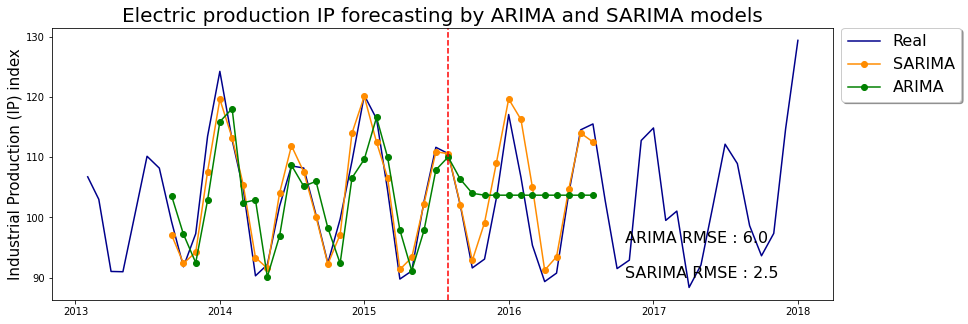

In [55]:
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by ARIMA and SARIMA models", fontsize=20)
plt.plot(dn[-60:].index,dn[-60:].values, color='darkblue', label='Real')
plt.plot(df_sarimax.index, df_sarimax.values, color='darkorange', label='SARIMA', marker='o')
plt.plot(df_arima.index, df_arima.values, color='green',label='ARIMA', marker='o')
plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.legend(bbox_to_anchor=(1, 1.03),fontsize=16,fancybox=True, shadow=True, frameon=True)
text = 'ARIMA RMSE : {:.1f}\n\nSARIMA RMSE : {:.1f} '.format(rmse_arima,rmse_sarima)
plt.text(mean_forecast.index[-1] + pd.DateOffset(days=80),90,text, fontsize=16)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [160]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(df['value'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
new= model_fit.forecast(24)

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [162]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(df['value']),trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)
print(model_fit.params)

new= model_fit.forecast(24)

{'smoothing_level': 0.5, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 68.39752666666662, 'initial_trend': -1.1764048484848448, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_19780\3650223120.py:3: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)


In [164]:
smooth = pd.DataFrame(new, columns=['Column_Name'])